# Portfolio of Satelite Orbits

<ul id="top">
  <li><a href="#Load-Packages">Load Packages</a></li>
  <li><a href="#ODE-of-the-Satellite">ODE of the Satellite</a></li>
  <li><a href="#Remote-sensing-satellite">Remote sensing satellite</a></li>
  <li><a href="#Geostationary-satellite">Geostationary satellite</a></li>
  <li><a href="#Highly-Eccentric-Orbit">Highly Eccentric Orbit</a></li>
  <li><a href="#All-Orbits">All Orbits</a></li>  
</ul> 

## Load Packages

In [8]:
using NBInclude
using Dates
using LinearAlgebra,Plots
using OrdinaryDiffEq
using IRKGaussLegendre

@nbinclude("./SAT_Force.ipynb")
@nbinclude("./SAT_Time.ipynb")
@nbinclude("./SAT_Kepler.ipynb")
@nbinclude("./SAT_RefSys.ipynb")

IERS_UT1_UTC (generic function with 1 method)

<a href="#top">Back to the top</a>

## ODE of the Satellite

In [9]:
function f_sat!(du,u,p,t)
"""
 Purpose:
    Computes the acceleration of an Earth orbiting satellite due to 
    - the Earth's harmonic gravity field
    - the gravitational perturbations of the Sun and Moon
    - the solar radiation pressure and
    - the atmospheric drag

 Input:
    Mjd_TT      Terrestrial Time (Modified Julian Date)
    r           Satellite position vector in the ICRF/EME2000 system
    v           Satellite velocity vector in the ICRF/EME2000 system
    Area        Cross-section
    mass        Spacecraft mass
    CR          Radiation pressure coefficient
    CD          Drag coefficient
  
 Output:
    Acceleration (a=d^2r/dt^2) in the ICRF/EME2000 system
"""    
  Mjd0_TT=p[1]
  Area=p[2]
  mass=p[3]
  CR=p[4]
  CD=p[5]
  n=Int(p[6])    
  m=Int(p[7])    
  FlagSun=Bool(p[8])
  FlagMoon=Bool(p[9])
  FlagSRad=Bool(p[10])
  FlagDrag=Bool(p[11])   
    
       
  r=u[1:3]
  v=u[4:6]

  r_Sun=zeros(3) 
  r_Moon=zeros(3)
  T=zeros(3,3)
  E=zeros(3,3)
    
    
  du[1:3]=v

#  Mjd_TT      Terrestrial Time (Modified Julian Date)    
#  Mjd_TT = (*p).Mjd0_TT + t/86400.0  
   Mjd_TT=Mjd0_TT+t/86400.0

#  Acceleration due to harmonic gravity field
#  Mjd_UT1 = Mjd_TT + (IERS::UT1_UTC(Mjd_TT)-IERS::TT_UTC(Mjd_TT))/86400.0;
  Mjd_UT1 = Mjd_TT + (IERS_UT1_UTC(Mjd_TT,UT1_TAI_,UTC_TAI_)-IERS_TT_UTC(Mjd_TT,UTC_TAI_))/86400.0
  T = NutMatrix(Mjd_TT)*PrecMatrix(MJD_J2000,Mjd_TT)
  E = GHAMatrix(Mjd_UT1)*T
  
#  println("r=",r,",E=",E)

#  du = AccelHarmonic (r,E,Grav.GM,Grav.R_ref,Grav.CS,n,m)
  du[4:6] = AccelHarmonic(r,E,GravJGM3.GM,GravJGM3.R,GravJGM3.CS,n,m)  
    
#  println("AccelHarmonic=",du[4:6])
    

# Luni-solar perturbations 

  Sun!(r_Sun,Mjd_TT)
  Moon!(r_Moon,Mjd_TT)

  if (FlagSun)  du[4:6] += AccelPointMass( r, r_Sun,  GM_Sun  ) end
#  println("FlagSun=",AccelPointMass( r, r_Sun,  GM_Sun  ))
  if (FlagMoon) du[4:6] += AccelPointMass( r, r_Moon, GM_Moon ) end
#  println("FlagMoon=",AccelPointMass( r, r_Moon, GM_Moon ))


# Solar radiation pressure

  if (FlagSRad) du[4:6] += AccelSolrad(r,r_Sun,Area,mass,CR,P_Sol,AU) end
#  println("FlagSRad=",AccelSolrad(r,r_Sun,Area,mass,CR,P_Sol,AU))

# Atmospheric drag

  if (FlagDrag) du[4:6] += AccelDrag( Mjd_TT, r, v, T, Area, mass, CD ) end
#  println("FlagDrag=",AccelDrag( Mjd_TT, r, v, T, Area, mass, CD ))

# Acceleration
  
  return du

end


N_JGM3 = 20
GM_Earth = 398600.4415e+9 
R_JGM3 = 6378.1363e3   # // Radius Earth [m]; 
CS_JGM3=zeros(N_JGM3+1,N_JGM3+1)
CS_JGM3!(CS_JGM3,Float64)

GravJGM3=GravModel{Float64}(N_JGM3,GM_Earth,R_JGM3,CS_JGM3)

GravModel{Float64}(20, 3.986004415e14, 6.3781363e6, [1.0 0.0 … 7.160542e-11 2.759192e-9; 0.0 0.0 … -1.008909e-10 3.216826e-10; … ; -2.197334e-8 -3.156695e-9 … -9.155723e-31 -1.237749e-31; 1.203146e-7 3.688524e-9 … -1.878413e-31 4.054696e-32])

### Initialize UT1-UTC and UTC-TAI time difference

In [10]:
#IERS::Set ( -0.05,-30.00, 0.0, 0.0 );
UT1_TAI_ = -0.05-30.00
UTC_TAI_ = -30.00
x_pole_  = 0.0/Arcs
y_pole_  = 0.0/Arcs;

<a href="#top">Back to the top</a>

## LEO Satellite

- Thallasa artikulua 
- Non-averaged regularized formulations as an alternative to semi-analytical orbit propagation (LEO numerical test case)

In [11]:
Mjd0_UTC = Mjd(2018,2,22,0,0,0.0)
Mjd0_UTC = 58171.738177
#Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC)/86400
Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC,UTC_TAI_)/86400

Kep=[6892.14e3, 0.0, 97.46*Rad, 281.0*Rad, 0.0, 0.0]
Y0=State(GM_Earth, Kep, 0.0 )
Area = 0.7     # [m^2]  
mass = 400.0  # [kg]
Y0

6-element Array{Float64,1}:
    1.3150823093945016e6
   -6.765511976126982e6
    0.0
 -969.2300281299292
 -188.39923249345554
 7540.501266344779

In [12]:
# 5 x 5 geopotential?
n=5
m=5
CR   = 1.3  # Solar Radiation?
CD   = 2.2
Sun  = true
Moon = true
SRad = true
Drag = true

Step =  120.0  # [s]
N_Step1 = 50   # ?
N_Step2 = 720  # ?

t0=0.
t1=Step*N_Step2
t1=Step*N_Step1
tspan=(t0,t1)

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_LEO=solve(prob,dt=Step,IRKGL16(),adaptive=false);

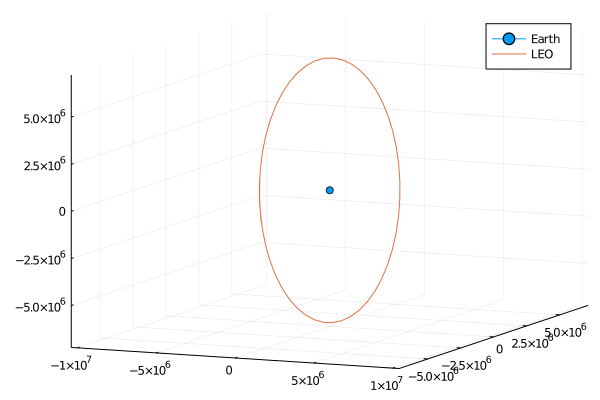

In [13]:
plot([0.],[0.],[0.],line=0,marker=4, label="Earth")
x=[u[1] for u in sol_LEO.u]
y=[u[2] for u in sol_LEO.u]
z=[u[3] for u in sol_LEO.u]
plot!(x,y,z, label="LEO",aspect_ratio=1)

<a href="#top">Back to the top</a>

## Remote sensing satellite

- Highly inclined polar orbits, to obtain a maximum coverage of the Earth's surface
(115.orr)

In [14]:
Mjd0_UTC = Mjd(1999,3,1,0,0,0.0)
#Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC)/86400
Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC,UTC_TAI_)/86400

Kep=[7178.0e3, 0.0010, 98.57*Rad, 0.0, 0.0, 0.0]
Y0=State(GM_Earth, Kep, 0.0 )
Area = 5.0     # [m^2]  Remote sensing satellite
mass = 1000.0  # [kg]
Y0

6-element Array{Float64,1}:
     7.170822e6
     0.0
     0.0
     0.0
 -1111.575722555183
  7376.070926571781

In [15]:
n=20
m=20
CR   = 1.3
CD   = 2.3
Sun  = true
Moon = true
SRad = true
Drag = true;

Step =  120.0  # [s]
N_Step1 = 50   # 100 mins
N_Step2 = 720  # 1 day

t0=0.
t1=Step*N_Step2
t1=Step*N_Step1
tspan=(t0,t1)

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_RS=solve(prob,dt=Step,IRKGL16(),adaptive=false);

<a href="#top">Back to the top</a>

##  Geostationary satellite

In [16]:
Mjd0_UTC = Mjd(1999,3,1,0,0,0.0)
#Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC)/86400
Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC,UTC_TAI_)/86400

Kep=[42166.0e3, 0.0004, 0.02*Rad, 0.0, 0.0, 0.0]
Y0=State(GM_Earth, Kep, 0.0 )
Area = 10.0     # [m^2]  Geostationary satellite
mass = 1000.0  # [kg]
Y0

6-element Array{Float64,1}:
    4.21491336e7
    0.0
    0.0
    0.0
 3075.823259987749
    1.0736649055318406

In [17]:
n=20
m=20
CR   = 1.3
CD   = 2.3
Sun  = true
Moon = true
SRad = true
Drag = true

Step =  1200.0  # [s]
N_Step1 = 72   # 1 day
N_Step2 = 144  # 2 days

t0=0.
t1=Step*N_Step2
t1=Step*N_Step1
tspan=(t0,t1)

p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_GS=solve(prob,dt=Step,IRKGL16(),adaptive=false);

<a href="#top">Back to the top</a>

##  Highly Eccentric Orbit

In [18]:
## Satellite Orbits 51.pag 
Mjd0_UTC = Mjd(1999,3,1,0,0,0.0)
#Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC)/86400
Mjd0_TT = Mjd0_UTC+IERS_TT_UTC(Mjd0_UTC,UTC_TAI_)/86400

Kep=[28196.776e3, 0.7679436, 20.315*Rad, 359.145*Rad, 179.425*Rad, 29.236*Rad]
Y0=State(GM_Earth, Kep, 0.0 )
Area = 10.0     # [m^2]  
mass = 1000.0  # [kg]
Y0

6-element Array{Float64,1}:
     1.1959886901183693e7
    -1.6289448826603336e7
    -5.963757695165331e6
  4724.300951633136
 -1109.9935305609756
  -384.7854410416176

In [19]:
n=20
m=20
CR   = 1.3
CD   = 2.3
Sun  = true
Moon = true
SRad = true
Drag = true

Step =  1200.0  # [s]
N_Step1 = 72   # 1 day
N_Step2 = 144  # 2 days

t0=0.
t1=Step*N_Step2
t1=Step*N_Step1
tspan=(t0,t1)

Sun  = false
Moon = false
SRad = false
Drag = false
p=[Mjd0_TT,Area,mass,CR,CD,n,m,Sun,Moon,SRad,Drag];

prob=ODEProblem( f_sat!,Y0,tspan,p)
sol_HEO=solve(prob,dt=Step,IRKGL16(),adaptive=false);

<a href="#top">Back to the top</a>

## All orbits

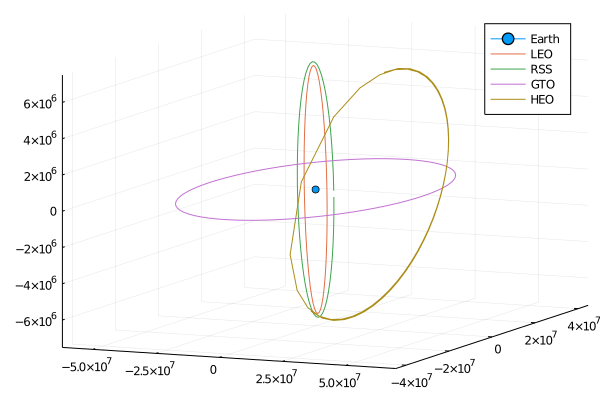

In [20]:
plot([0.],[0.],[0.],line=0,marker=4, label="Earth")

x=[u[1] for u in sol_LEO.u]
y=[u[2] for u in sol_LEO.u]
z=[u[3] for u in sol_LEO.u]
plot!(x,y,z, label="LEO", aspect_ratio=1)

x=[u[1] for u in sol_RS.u]
y=[u[2] for u in sol_RS.u]
z=[u[3] for u in sol_RS.u]
plot!(x,y,z, label="RSS",aspect_ratio=1)

x=[u[1] for u in sol_GS.u]
y=[u[2] for u in sol_GS.u]
z=[u[3] for u in sol_GS.u]
plot!(x,y,z,label="GTO",aspect_ratio=1)

x=[u[1] for u in sol_HEO.u]
y=[u[2] for u in sol_HEO.u]
z=[u[3] for u in sol_HEO.u]
plot!(x,y,z,label="HEO",aspect_ratio=1)

In [21]:
"""

plot([0.],[0.],line=0,marker=4, label="Earth")

x=[u[1] for u in sol_RS.u]
y=[u[2] for u in sol_RS.u]
plot!(x,y,label="RSS",aspect_ratio=1)
x=[u[1] for u in sol_LEO.u]
y=[u[2] for u in sol_LEO.u]
plot!(x,y,label="LEO",aspect_ratio=1)
x=[u[1] for u in sol_GS.u]
y=[u[2] for u in sol_GS.u]
plot!(x,y,label="GTO",aspect_ratio=1)
x=[u[1] for u in sol_HEO.u]
y=[u[2] for u in sol_HEO.u]
plot!(x,y,label="HEO",aspect_ratio=1)

"""

"\nplot([0.],[0.],line=0,marker=4, label=\"Earth\")\n\nx=[u[1] for u in sol_RS.u]\ny=[u[2] for u in sol_RS.u]\nplot!(x,y,label=\"RSS\",aspect_ratio=1)\nx=[u[1] for u in sol_LEO.u]\ny=[u[2] for u in sol_LEO.u]\nplot!(x,y,label=\"LEO\",aspect_ratio=1)\nx=[u[1] for u in sol_GS.u]\ny=[u[2] for u in sol_GS.u]\nplot!(x,y,label=\"GTO\",aspect_ratio=1)\nx=[u[1] for u in sol_HEO.u]\ny=[u[2] for u in sol_HEO.u]\nplot!(x,y,label=\"HEO\",aspect_ratio=1)\n\n"